<a href="https://colab.research.google.com/github/Danie8904/prueba_NVIDIA_yahoo_Finance/blob/main/Nvidia_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proceso Modelamiento ML Ops - Yahoo Finance - Nvidia
## Realizado por Daniel Muñoz Palma

## Librerias

In [1]:
!pip install yfinance -q

In [2]:
import yfinance as yf

### 1. Punto: Extraer datos históricos de la compañía Nvidia y sus componentes desde Yahoo Finance utilizando Python

In [3]:
nvidia = yf.Ticker("NVDA")

# Se descargar datos históricos de NVDAD últimos 10 años
hist = nvidia.history(period="10y")

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-06-18 00:00:00-04:00,0.526618,0.534363,0.525166,0.530974,299404000,0.0,0.0
2015-06-19 00:00:00-04:00,0.530974,0.535330,0.524440,0.529280,355656000,0.0,0.0
2015-06-22 00:00:00-04:00,0.530248,0.533152,0.519116,0.527102,514236000,0.0,0.0
2015-06-23 00:00:00-04:00,0.528070,0.532184,0.509435,0.513550,414064000,0.0,0.0
2015-06-24 00:00:00-04:00,0.512823,0.515486,0.506047,0.508467,253368000,0.0,0.0


In [5]:
# Exportación de datos a CSV
hist.to_csv("nvidia_10_anios.csv")

##  Gráfico Comportamiento histórico NVIDIA ("Precio de Cierre")

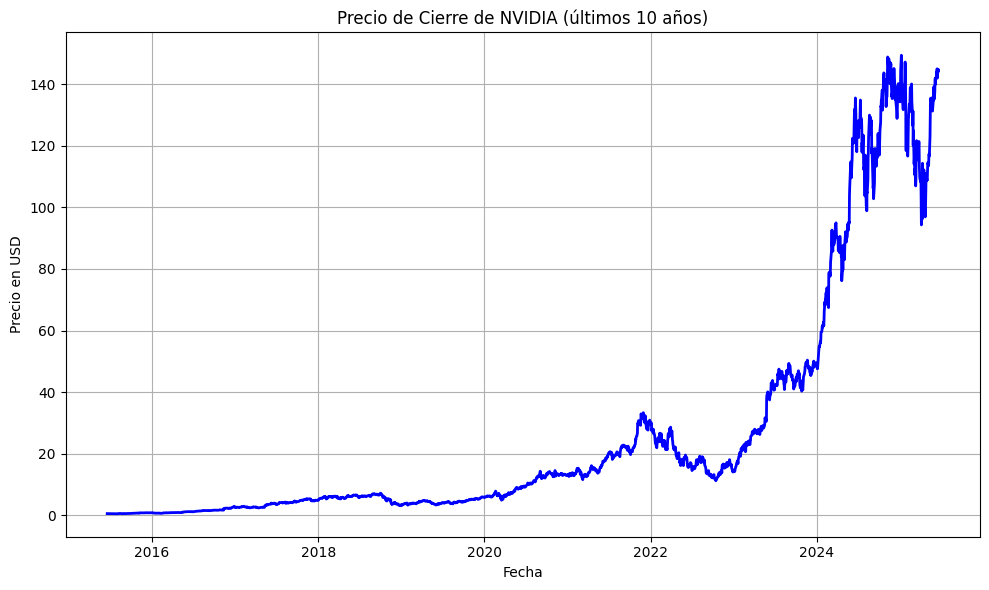

In [6]:
import matplotlib.pyplot as plt

hist = hist.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(hist['Date'], hist['Close'], color='blue', linewidth=2)

plt.title("Precio de Cierre de NVIDIA (últimos 10 años)")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
df = hist.reset_index()[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [20]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [21]:
df

,ds,y
0,2015-06-18,0.530974
1,2015-06-19,0.529280
2,2015-06-22,0.527102
3,2015-06-23,0.513550
4,2015-06-24,0.508467
...,...,...
2511,2025-06-12,145.000000
2512,2025-06-13,141.970001
2513,2025-06-16,144.690002
2514,2025-06-17,144.119995


In [17]:
!pip install prophet -q

In [22]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gqye6c3/mvg2jxe2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gqye6c3/j3cyaswc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74579', 'data', 'file=/tmp/tmp0gqye6c3/mvg2jxe2.json', 'init=/tmp/tmp0gqye6c3/j3cyaswc.json', 'output', 'file=/tmp/tmp0gqye6c3/prophet_modelv9bk7owl/prophet_model-20250618192538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


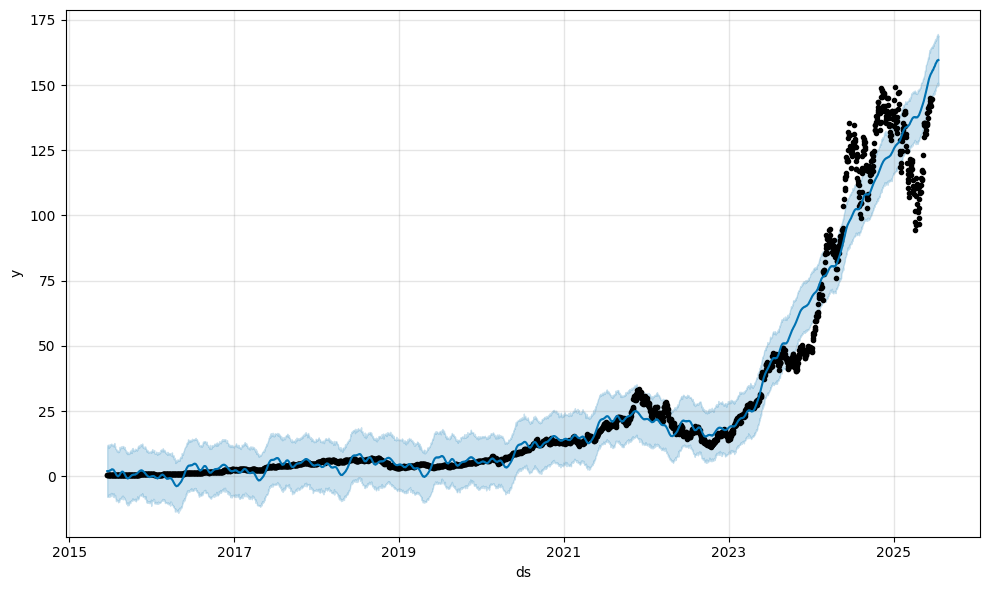

In [23]:
# Predecir los próximos 30 días
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Graficar resultado
model.plot(forecast);

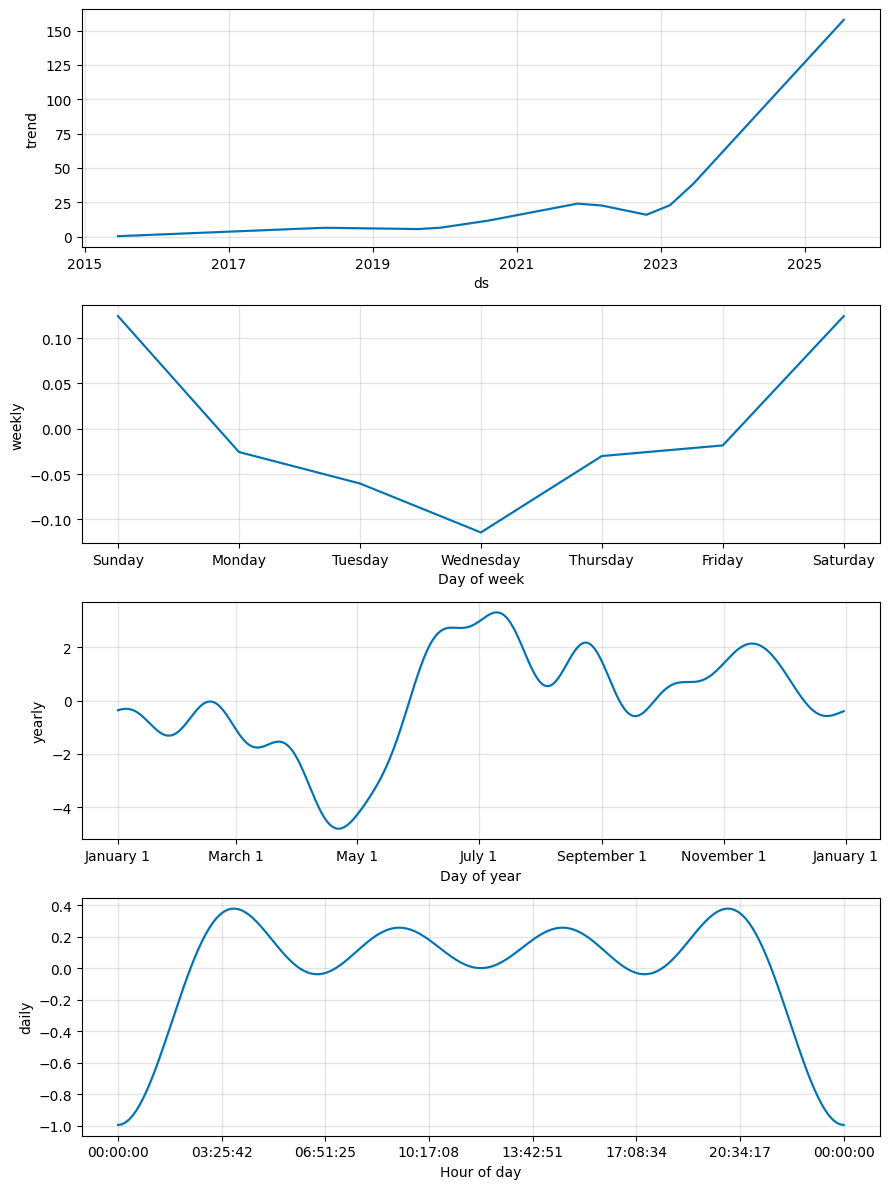

In [24]:
from matplotlib import pyplot as plt

# Descomposición de la serie
fig = model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Unir forecast y datos reales
df_pred = forecast[['ds', 'yhat']].copy()
df_eval = df.merge(df_pred, on='ds')

# Variables reales vs. predichas
y_true = df_eval['y']
y_pred = df_eval['yhat']

# Cálculo de errores
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
# Crear DataFrame resumen
error_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'RMSE', 'MAPE(%)'],
    'Valor': [mae, mse, rmse, mape]
})

# Redondear para presentación
error_df['Valor'] = error_df['Valor'].round(2)

error_df


,Métrica,Valor
0,MAE,4.14
1,MSE,56.11
2,RMSE,7.49
3,MAPE(%),43.38
